## Exercise 

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

### Example 2D dataset

This example dataset consists of 2 network server statistics across several machines: the latency and throughput of each machine.

#### Importing libraries

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt
import matplotlib as mpl

# Will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

#### Load and visualize data

I am going to start by visualizing the data to see what I am working with.

Text(0, 0.5, 'Throughput (mb/s)')

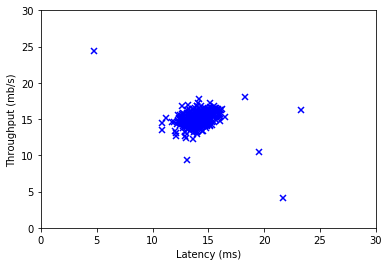

In [2]:
# Load dataset
data = loadmat('Data/ex8data1.mat')
x, x_cv, y_cv = data['X'], data['Xval'], data['yval'][:, 0]

# Plot data
plt.plot(x[:, 0], x[:, 1], 'x', mec='b', mew=1.5, ms=6)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

#### Gaussian distribution

To perform anomaly detection, I will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), I want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 \dots n$, I will find the parameters $\mu_i$ and $\sigma_i^2$ that fit the training examples.

The Gaussian distribution is given by:

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

#### Estimating parameters for a Gaussian distribution

I can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, I will use: 

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance, I will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

To compute these values, I will write the function `estimateGaussian`.

In [3]:
def estimateGaussian(x):
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    
    # Another possible solution
    #m = x.shape[0]
    #mean = (1 / m) * np.sum(x, axis=0)
    #variance = (1 / m) * np.sum((x - mu)**2, axis=0)
    
    return mean, variance

#### Multivariate gaussian distribution

After computing the values of the mean and the variance for each training example, I can use these values to compute the probability for each of the training example. For this dataset, I will use the multivariate Gaussian distribution instead of the regular Gaussian distribution and will write the code in the function `multivariateGaussian`.

To visualize the Gaussian distribution, I will plot the probability density function over the data to see where each of the examples fall in terms of this distribution. To do this I will create the function `plotDistribution`.

In [4]:
def multivariateGaussian(x, mean, variance):
    k = x.shape[1]

    # Turn variance vector into a covariance matrix where the values are in the diagonal of the matrix
    if variance.ndim == 1:
        covariance = np.diag(variance)
        
    norm_const = np.sqrt((2 * np.pi)**k * np.linalg.det(covariance))
    probabilities = np.exp(-(1 / 2) * np.sum(np.dot(x - mean, np.linalg.pinv(covariance)) * (x - mean), axis=1)) / norm_const
                       
    return probabilities

In [5]:
def plotDistribution(x, mean, variance):
    x1, x2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    z = multivariateGaussian(np.stack([x1.ravel(), x2.ravel()], axis=1), mean, variance)
    z = z.reshape(x1.shape)

    # Plot data
    plt.plot(x[:, 0], x[:, 1], 'bx', mec='b', mew=2, ms=8)
    plt.axis([0, 30, 0, 30])
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    
    # Plot contours
    plt.contour(x1, x2, z, levels=10**(np.arange(-20., 1, 3)), zorder=100)

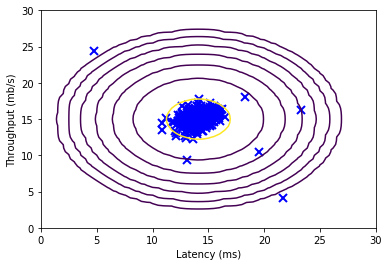

In [6]:
# Estimating Gaussian parameters
mean, variance = estimateGaussian(x)

# Run multivariate Gaussian distribution
probabilities_train = multivariateGaussian(x, mean, variance)

# Plot Gaussiandistribution
plotDistribution(x, mean, variance)

From the plot, we can see that most of the examples are in the region with the highest probability, while
the anomalous examples are in the regions with lower probabilities.

#### Selecting the threshold $\varepsilon$

Now that I have estimated the Gaussian parameters, I can check which examples have a high probability given this distribution and which examples have a low probability. The low probability examples are likely to be the anomalies in the dataset. 

To differentiate low probability from high probability, we use a threshold value $\varepsilon$. If an example $x$ has a low probability, $p(x) < \varepsilon$, then it is considered to be an anomaly.

I will write the function `selectThreshold` which computes the $F_1$ score on the cross validation set for different threshold value $\varepsilon$ and selects the value that maximizes $F_1$ score.

You should see a value for `epsilon` of about 8.99e-05.

In [7]:
def selectThreshold(y_cv, probabilities):
    best_epsilon = 0
    best_F1_score = 0
    F1_score = 0
   
    for epsilon in np.linspace(1.01*min(probabilities), max(probabilities), 1000):
        # Gives binary vector of 0's and 1's for the predictions (y = 1 for anomalies, y = 0 for normal examples)
        predictions = (probabilities < epsilon)
        
        # F1 score
        true_positives = np.sum(predictions[y_cv == 1] == y_cv[y_cv == 1])
        num_pos_predictions = len(predictions[predictions == 1])
        actual_pos_values = len(y_cv[y_cv == 1])
    
        precision = true_positives / num_pos_predictions
        recall = true_positives / actual_pos_values
        F1_score = (2 * recall * precision) / (recall + precision)
        
        if F1_score > best_F1_score:
            best_F1_score = F1_score
            best_epsilon = epsilon

    return best_epsilon, best_F1_score

Best epsilon found using cross validation set: 8.99985e-05
Best F1 score on cross validation set: 0.875


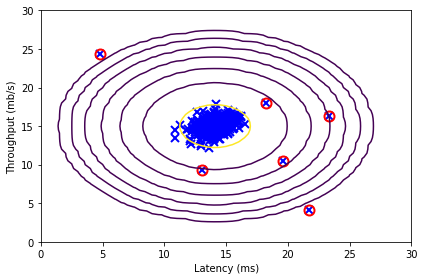

In [8]:
# Run multivariate Gaussian distribution to get probabilities on cross validation set
probabilities_cv = multivariateGaussian(x_cv, mean, variance)

# Select threshold value (epsilon)
epsilon, F1_score = selectThreshold(y_cv, probabilities_cv)
print(f'Best epsilon found using cross validation set: {round(epsilon, 10)}')
print(f'Best F1 score on cross validation set: {round(F1_score, 4)}')

# Plot the Gaussian fit
plotDistribution(x, mean, variance)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

# Find the outliers (anomalies) in the training set
outliers = (probabilities_train < epsilon)

# Draw a red circle around the outliers
plt.plot(x[outliers, 0], x[outliers, 1], 'ro', ms=10, mfc='None', mew=2)

### High dimensional dataset

Now I will run the anomaly detection algorithm I implemented on a more realistic and more difficult dataset. In this dataset, each example is described by 11 features capturing many more properties of the compute servers but only some features indicate whether a point is an outlier or not. 

The process will be to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$) on the training set using `estimateGaussian`; evaluate the probabilities for both the training set `x` and the cross-validation set `x_cv` using `multivariateGaussian`; and finally to select the best threshold $\varepsilon$ using `selectThreshold`. You should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In [9]:
# Load the larger dataset
data = loadmat('Data/ex8data2.mat')
x, x_cv, y_cv = data['X'], data['Xval'], data['yval'][:, 0]

# Estimate Gaussian parameters
mean, variance = estimateGaussian(x)

# Run multivariate Gaussian distribution on training set 
probabilities_train = multivariateGaussian(x, mean, variance)

# Run multivariate Gaussian distribution on cross validation set
probabilities_cv = multivariateGaussian(x_cv, mean, variance)

# Find the best threshold value
epsilon, F1_score = selectThreshold(y_cv, probabilities_cv)

print(f'Best epsilon found using cross validation set: {epsilon}')
print(f'Best F1 score on cross validation set: {round(F1_score, 4)}')
print(f'Number of outliers found: {np.sum(probabilities_train < epsilon)}')

Best epsilon found using cross validation set: 1.378607498794764e-18
Best F1 score on cross validation set: 0.6154
Number of outliers found: 117
